# Data

To fetch the data we created a repository that housed a script that fetches the data.<br>
The link to the repository can be found here : <br>
https://github.com/sirandreww/operate_first_prometheus_data.git

We have added more information about what data is being fetched and how in that repository.
The main point being that the data we are pulling is:

1. Memory-usage data for each container using this Prometheus query `sum(container_memory_working_set_bytes{name!~".*prometheus.*", image!="", container!="POD", cluster="moc/smaug"}) by (container, pod, namespace, node)`.
   
2. CPU-usage data for each container using this Prometheus query `sum(rate(container_cpu_usage_seconds_total{name!~".*prometheus.*", image!="", container!="POD", cluster="moc/smaug"}[5m])) by (container, pod, namespace, node)`.
   
3. Memory-usage percentage data for each node using this Prometheus query `node_memory_Active_bytes/node_memory_MemTotal_bytes*100`.


The data is then merged and turned into json files in that repository. We have created code here that takes those json files and imports them into custom datasets for our project. Let's take a look shall we!

In [1]:
import src.data_set as ds

Getting the dataset for container memory data, for the cointainer bridge-marker.

In [2]:
dataset = ds.get_data_set(
    metric="container_mem",
    application_name="bridge-marker",
    path_to_data="./data/"
)

Now let's plot some samples in the data to get a visual on what we're looking at.

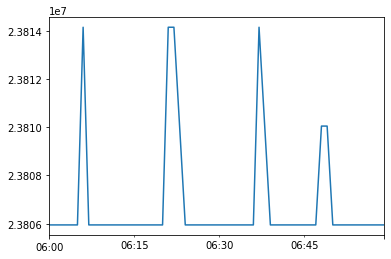

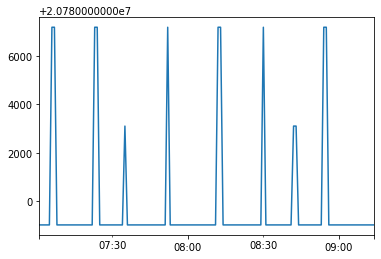

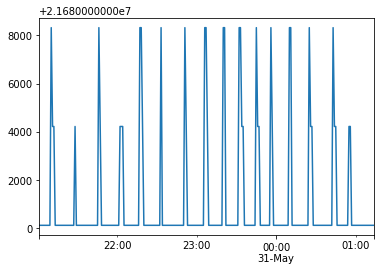

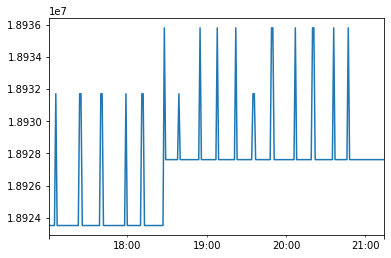

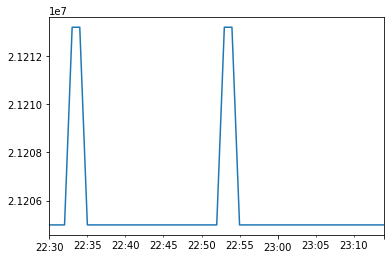

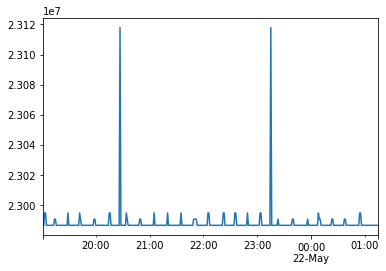

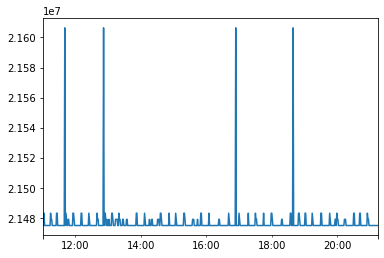

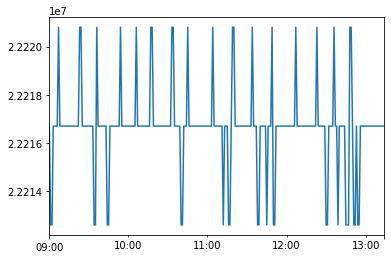

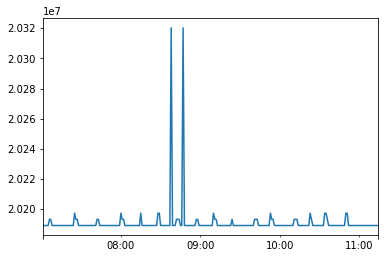

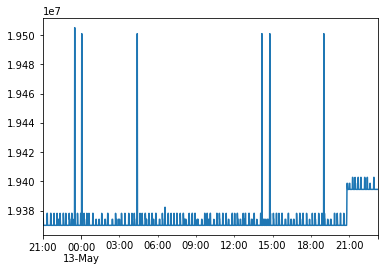

In [3]:
dataset.plot_dataset(number_of_samples=10)

As we can see, we have a sample for each minute, we can further subsample the data to get data that is easier to generalize. Here we change the dataset so it is has samples 5 minutes appart:

In [4]:
dataset.sub_sample_data(sub_sample_rate=5)

Let's plot again to see how the samples look now.

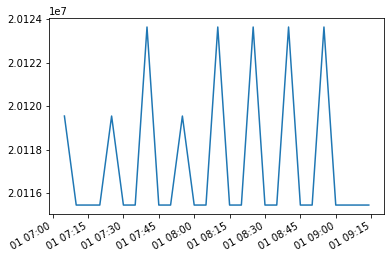

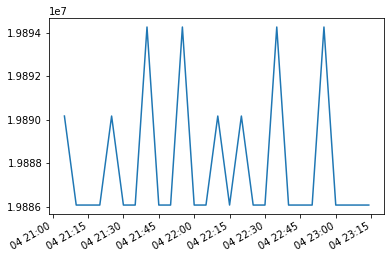

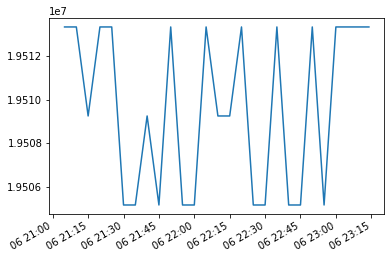

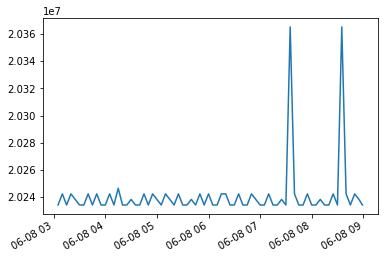

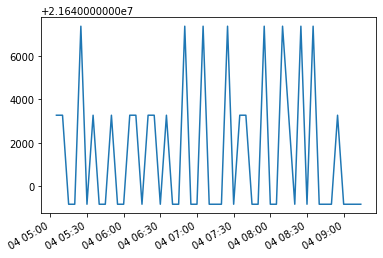

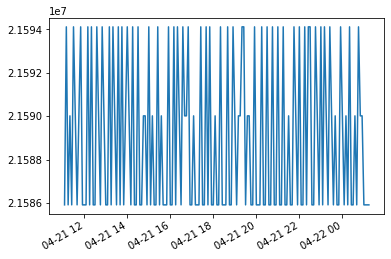

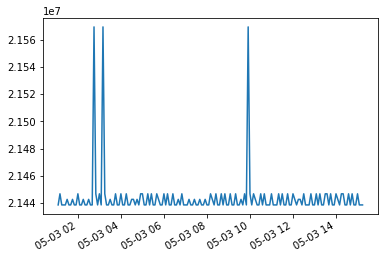

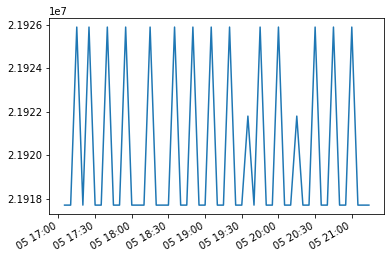

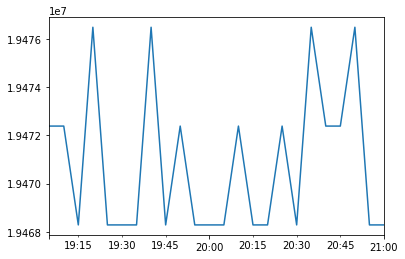

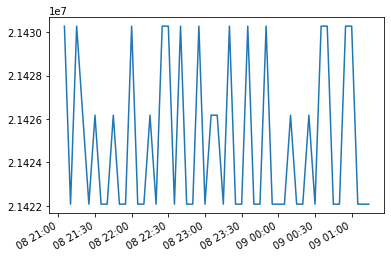

In [5]:
dataset.plot_dataset(number_of_samples=10)

The data is highly variable and is not normalized, let's normalize it.